# Health_Insurance_Membership_Survival_Model


#### Required Packages and Running Enviornment

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn import preprocessing
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import median_survival_times

plt.style.use('fivethirtyeight')

import os, warnings
warnings.filterwarnings("ignore")

In [2]:
import platform
print("Python version:", platform.python_version())

Python version: 3.8.5


## Data Load

In [3]:
# Data Load
df = pd.read_csv("dataset.csv")

In [4]:
df.head()

,Customer ID,Membership Start Date,Transaction Date,Payment Type,Revenue
0,386379,2019-02-19,2019-02-18,Annual Fee,285.9
1,386379,2019-02-19,2019-02-18,Monthly Fee,26.5
2,386379,2019-02-19,2019-03-19,Monthly Fee,26.5
3,386379,2019-02-19,2019-04-19,Monthly Fee,26.5
4,386379,2019-02-19,2019-05-19,Monthly Fee,26.5


In [5]:
# Check any missing values
df.isnull().sum()

Customer ID              0
Membership Start Date    0
Transaction Date         0
Payment Type             0
Revenue                  0
dtype: int64

In [6]:
# Change date format
df['Transaction Date'] = df['Transaction Date'].astype('datetime64[ns]')
df['Membership Start Date'] = df['Membership Start Date'].astype('datetime64[ns]')

In [7]:
# Create Cohort for later analysis
df['Cohort'] = pd.to_datetime(df['Membership Start Date']).dt.to_period('M')

# Create tranaction month
df['Trans_Dt'] = pd.to_datetime(df['Transaction Date']).dt.to_period('M') 
df['Trans_Month_Only'] = df['Transaction Date'].dt.month

# Calculate Age = Month Since Membership 
df['Age'] =  df['Trans_Dt'].astype(int)- df['Cohort'].astype(int)

# Floor negative Age. ALL observations will start from Age=0
df['Age'] = np.where(df['Age']<0, 0, df['Age'])

In [8]:
df.head()

,Customer ID,Membership Start Date,Transaction Date,Payment Type,Revenue,Cohort,Trans_Dt,Trans_Month_Only,Age
0,386379,2019-02-19,2019-02-18,Annual Fee,285.9,2019-02,2019-02,2,0
1,386379,2019-02-19,2019-02-18,Monthly Fee,26.5,2019-02,2019-02,2,0
2,386379,2019-02-19,2019-03-19,Monthly Fee,26.5,2019-02,2019-03,3,1
3,386379,2019-02-19,2019-04-19,Monthly Fee,26.5,2019-02,2019-04,4,2
4,386379,2019-02-19,2019-05-19,Monthly Fee,26.5,2019-02,2019-05,5,3


Min of Age: 0
Max of Age: 10


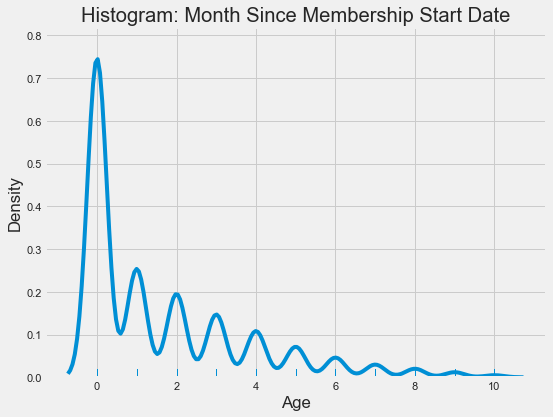

In [9]:
#Histogram of Age
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.distplot(df['Age'], rug=True, hist=False)
ax.set_title("Histogram: Month Since Membership Start Date")
print("Min of Age:", df['Age'].min())
print("Max of Age:", df['Age'].max())

## Q1-a) 1. Which month had the highest revenue (by "Transaction Date")?

Trans_Month_Only
12    1255965.000
11    1166113.000
2      946181.200
3      942902.100
1      919455.300
10     804539.200
4      741514.300
8      709209.205
9      579243.110
7      545955.485
5      127041.910
6      106774.470
Name: Revenue, dtype: float64


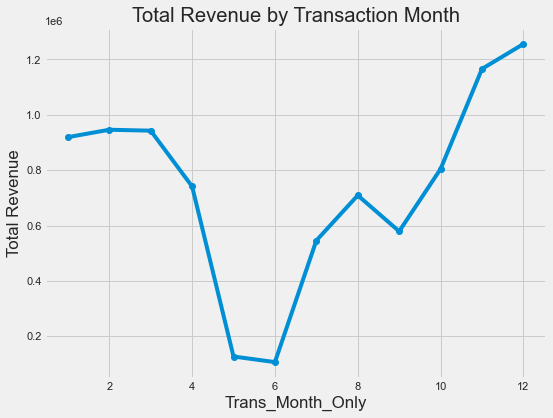

In [10]:
# By Month Only: December has the highest revenue
test =df.groupby(['Trans_Month_Only'])['Revenue'].sum()
print (test.sort_values(ascending=False).nlargest(12))

# Plot by Month
test.plot(marker='o', figsize=(8,6))
plt.ylabel('Total Revenue')
plt.title("Total Revenue by Transaction Month")
plt.show()

Trans_Dt
2018-12    1255965.000
2018-11    1166113.000
2019-02     946181.200
2019-03     942902.100
2019-01     919455.300
2018-10     804539.200
2019-04     741514.300
2018-08     709209.205
2018-09     579243.110
2018-07     545955.485
2019-05     126380.700
2018-06     105882.770
Freq: M, Name: Revenue, dtype: float64


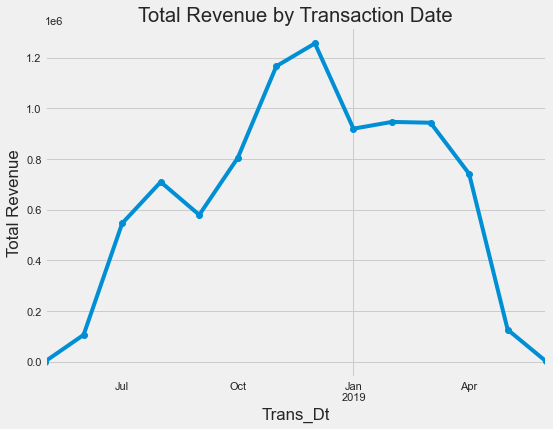

In [11]:
# By Transaction Date (YYYY-MM): 2018-12 has the highest revenue
test =df.groupby(['Trans_Dt'])['Revenue'].sum()
print (test.sort_values(ascending=False).nlargest(12))

# Plot 
test.plot(marker='o', figsize=(8,6))
plt.ylabel('Total Revenue')
plt.title("Total Revenue by Transaction Date")
plt.show()

## Q1-b) What was the percentage of revenue for that month by payment type?

In [12]:
# Select trans month = 2018-12
Dec =  df.loc[df['Trans_Dt']=="2018-12"]

In [13]:
# 91.6% of revenue in December is from Annual fee, 8.4% is from Monthly fee
dec_rev = Dec.groupby(["Payment Type"])['Revenue'].agg(["sum"]).reset_index()
dec_rev['Pecent'] = (dec_rev['sum'] / Dec['Revenue'].sum()).round(3)*100
dec_rev

,Payment Type,sum,Pecent
0,Annual Fee,1150124.0,91.6
1,Monthly Fee,105841.0,8.4


## Q2) How many members started their memberships in December 2018?

In [14]:
Dec2018= df.loc[df['Cohort']=='2018-12']

In [15]:
# 1254 people started their memberships in December 2018
Dec2018_Cohort = Dec2018.groupby('Customer ID')['Customer ID'].agg('nunique').sum()
print("unique number of customers started membership in Dec-2018:", Dec2018_Cohort)

unique number of customers started membership in Dec-2018: 1254


## Q3) On average, for how many months did members who started their memberships in July 2018 continue to pay the monthly fee?

In [16]:
# Pick July 2018 Data
Jul2018= df.loc[df['Cohort']=='2018-07']

In [17]:
# Pick the last transaction date that July Cohort paid their membership
Last_transaction_df = Jul2018.sort_values('Transaction Date').groupby('Customer ID').tail(1)
Last_transaction_df.head()

,Customer ID,Membership Start Date,Transaction Date,Payment Type,Revenue,Cohort,Trans_Dt,Trans_Month_Only,Age
20892,312897,2018-07-01,2018-05-31,Monthly Fee,26.500,2018-07,2018-05,5,0
35127,314200,2018-07-01,2018-06-05,Annual Fee,827.625,2018-07,2018-06,6,0
20918,315406,2018-07-01,2018-06-11,Monthly Fee,26.500,2018-07,2018-06,6,0
35159,316393,2018-07-01,2018-06-14,Annual Fee,382.890,2018-07,2018-06,6,0
35174,316788,2018-07-01,2018-06-15,Monthly Fee,26.500,2018-07,2018-06,6,0


In [18]:
# Calculate the average in months (Note: Negative Ages are floored to Zero.)

#including annual fees
membership_duration = Last_transaction_df['Age'].mean()
print ('Avg Membership Duration for July 2018 Cohort inculding annual fees  (in months): {:.2f}'.format(membership_duration))

#only count monthly fees
membership_duration = Last_transaction_df.loc[Last_transaction_df['Payment Type']=="Monthly Fee"]['Age'].mean()
print ('Avg Membership Duration for July 2018 Cohort excluding annual fees  (in months): {:.2f}'.format(membership_duration))

Avg Membership Duration for July 2018 Cohort inculding annual fees  (in months): 3.94
Avg Membership Duration for July 2018 Cohort excluding annual fees  (in months): 4.68


## Q4). Assume that transactions for June 2019 are incomplete and that transactions beyond June 2019 are unobserved. What type of statistical or machine learning modeling technique(s) would you use to build a predictive model of customer retention?

#### If our objective is to simply identify customers who no longer pay the monthly fees after June 2019, then we can employ classification models such as logistic regression or ensemble learning algorithms such as GBM or XGB.

#### If our objective is to find the survival time, that is time to end their membership, then I would explore survival analysis trying several algorithms such as Cox's regression or accelerated failure time model.  

#### In our data where we have a limited number of features and the most important being the time since membership, I think the survival analysis is more applicable. We can try to use these binary classification models by carefully constructing the age feature via fractional polynomial or kernel regression to incorporate the non-linearity trend that age exhibits w.r.t. customer churn. 

## Q5-a). How many customers paid the Monthly Fee in May 2019? 

In [19]:
# Pick May 2019 Data
May2019= df.loc[df['Trans_Dt']=='2019-05']

In [20]:
# Get total number and the unique number of customers who paid the monthly fee
May2019_fee_total = May2019.loc[May2019['Payment Type']=="Monthly Fee"]['Customer ID'].agg('count')
print('The total number of Customers paid the Monthly Fee in May 2019:', May2019_fee_total )

May2019_fee_unique = May2019.loc[May2019['Payment Type']=="Monthly Fee"]['Customer ID'].agg('nunique')
print('The unique number of Customers paid the Monthly Fee in May 2019:', May2019_fee_unique )

The total number of Customers paid the Monthly Fee in May 2019: 4585
The unique number of Customers paid the Monthly Fee in May 2019: 4533


## Q5-b) Predict the Membership End Date for these customers.


#### Let's examine each cohort's survivial trend to see they are close to each other. 

Although some variabilities can be seen among these survival curves, the ealier cohorts show that about 20% of paying memebers retained after 8, 9, or 10 months.

In [21]:
# Roll-up  Cohorts to monthly 
cohorts = df.groupby(['Cohort', 'Age']).agg({'Customer ID': pd.Series.nunique,
                       'Revenue': np.sum})

# Rename Columns
cohorts.rename(columns={'Customer ID': 'Num_Customers',
                        'Revenue': 'Revenue'}, inplace=True)

# Reset Index
cohorts.reset_index(inplace=True)
cohorts.set_index(['Cohort', 'Age'], inplace=True)

# create a series that holds each cohort's group size
cohort_group_size = cohorts['Num_Customers'].groupby(level=0).first()

# create retention table
survival = cohorts['Num_Customers'].unstack(0).divide(cohort_group_size, axis=1)
survival

Cohort,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04
Age,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.689847,0.677237,0.654645,0.646996,0.668232,0.726038,0.699938,0.683930,0.647681,0.648598
2,0.586926,0.556059,0.563934,0.535408,0.541471,0.624601,0.614473,0.551409,0.564687,0.001869
3,0.517385,0.466591,0.464481,0.428112,0.451487,0.551917,0.533999,0.489718,NaN,NaN
4,0.445063,0.397508,0.382514,0.348712,0.394366,0.484026,0.484716,NaN,NaN,NaN
5,0.375522,0.325028,0.324590,0.311159,0.342723,0.439297,NaN,NaN,NaN,NaN
6,0.311544,0.286523,0.286339,0.269313,0.306729,NaN,NaN,NaN,NaN,NaN
7,0.265647,0.267271,0.253552,0.248927,NaN,NaN,NaN,NaN,NaN,NaN
8,0.254520,0.234428,0.229508,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<function matplotlib.pyplot.show(close=None, block=None)>

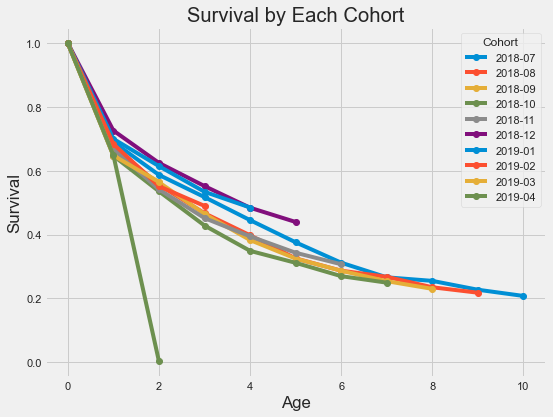

In [22]:
#Plot: Survival by Each Cohort
survival.plot(marker='o',figsize=(8,6))
plt.ylabel('Survival')
plt.title("Survival by Each Cohort")
plt.show

## Cox’s proportional hazard regression model

To predict the membership end date, we will be utilizing the Cox's proportional hazard regression model. 

More info can be found here: 
https://en.wikipedia.org/wiki/Proportional_hazards_model#The_Cox_model

### Let's first create a flag, "Close" that identifes customers who no longer pay the membership fees. 

In [23]:
# pick last transaction date for each customer
last_trans = df.sort_values('Transaction Date').groupby('Customer ID').tail(1)

#exclude trasnactions in May-2019 and June-2019
last_trans = last_trans[last_trans["Trans_Dt"]<="2019-04"]

# set the last transaction as "close"
last_trans['Close']=1

In [24]:
#merge with the original data 
df_new= df.merge(last_trans, how='left', on =['Customer ID', 'Membership Start Date', 'Transaction Date', 'Payment Type', 
                                               'Cohort', 'Age'])

# fill in NaN with zero
df_new['Close']=df_new['Close'].fillna(0)
df_new['Close']= df_new['Close'].astype(bool)

In [25]:
# Split the data into two data sets based on transaction date
df1 = df_new.loc[(df_new['Transaction Date']<pd.Timestamp(2019,5,1))]
df2 = df_new.loc[(df_new['Transaction Date']>=pd.Timestamp(2019,5,1))]

### Prepare Data and Features that include duration (Age) and censorship (Close)

In [26]:
# set training dat as data with training date prior to May-2019

# select the following features: payment type, age, cohort, close
train_df = df1[['Payment Type', 'Age', 'Cohort', 'Close' ]]

In [27]:
# create a function to process categorical features 
def fn_cat_feature(data, features):
    
    for f in data[features]:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(data[f].values))
        data[f] = lbl.transform(list(data[f].values))

In [28]:
# Process the categorical features
fn_cat_feature(train_df, ['Cohort', 'Close', 'Payment Type'])

### Cox Proportional Hazard Model, 10-fold CV is used

 The Concordance Index evaluates the accuracy of the ordering of predicted time. This model achieved 66% Concordance. Considering that random predictions will have C-index of 50%, it is a reasonably fitted model.

In [29]:
cph = CoxPHFitter()
scores = k_fold_cross_validation(cph, train_df, 'Age', event_col='Close', k=10)
print(scores)

cph.print_summary()

[-1.1334903917861203, -1.1267694504298784, -1.130431336640594, -1.1317086564273706, -1.13001646221301, -1.134597008043256, -1.1320350730741766, -1.118297677783745, -1.1239420692276287, -1.1355847647784045]


<lifelines.CoxPHFitter: fitted with 40383 total observations, 34385 right-censored observations>
             duration col = 'Age'
                event col = 'Close'
      baseline estimation = breslow
   number of observations = 40383
number of events observed = 5998
   partial log-likelihood = -58766.72
         time fit was run = 2020-12-09 05:21:41 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Payment Type  -1.06       0.35       0.04            -1.13            -0.99                 0.32                 0.37
Cohort         0.11       1.12       0.01             0.10             0.13                 1.11                 1.13

                  z      p   -log2(p)
covariate                            
Payment Type -29.30 <0.005     624.41
Cohort        20.25 <0.005     300.46
---
Concordance = 0.66
Partial AIC = 117537.44
log-likelihood ratio test = 1437.82 on 2 df
-log2(p) of ll-ratio test = inf

In [30]:
# Prepare the test data set 
pred_df = df2[['Payment Type', 'Age', 'Cohort', 'Close']]
fn_cat_feature(pred_df, ['Cohort', 'Close', 'Payment Type'])

In [31]:
# Predict survival rate on the test data set
cph_pred = cph.predict_survival_function(pred_df)
cph_pred

,4,9,14,24,31,39,67,102,108,125,...,49431,49434,49437,49440,49443,49446,49451,49454,49457,49464
0.0,0.935588,0.935588,0.935588,0.942353,0.948427,0.953877,0.967065,0.970576,0.942353,0.948427,...,0.919690,0.919690,0.919690,0.919690,0.919690,0.919690,0.919690,0.919690,0.919690,0.919690
1.0,0.868072,0.868072,0.868072,0.881464,0.893581,0.904528,0.931308,0.938508,0.881464,0.893581,...,0.837027,0.837027,0.837027,0.837027,0.837027,0.837027,0.837027,0.837027,0.837027,0.837027
2.0,0.804548,0.804548,0.804548,0.823707,0.841176,0.857068,0.896381,0.907054,0.823707,0.841176,...,0.760747,0.760747,0.760747,0.760747,0.760747,0.760747,0.760747,0.760747,0.760747,0.760747
3.0,0.741674,0.741674,0.741674,0.766051,0.788465,0.809006,0.860433,0.874543,0.766051,0.788465,...,0.686760,0.686760,0.686760,0.686760,0.686760,0.686760,0.686760,0.686760,0.686760,0.686760
4.0,0.677465,0.677465,0.677465,0.706622,0.733680,0.758683,0.822121,0.839732,0.706622,0.733680,...,0.612852,0.612852,0.612852,0.612852,0.612852,0.612852,0.612852,0.612852,0.612852,0.612852
5.0,0.614509,0.614509,0.614509,0.647757,0.678921,0.707976,0.782761,0.803785,0.647757,0.678921,...,0.542118,0.542118,0.542118,0.542118,0.542118,0.542118,0.542118,0.542118,0.542118,0.542118
6.0,0.563568,0.563568,0.563568,0.599649,0.633769,0.665832,0.749420,0.773182,0.599649,0.633769,...,0.486225,0.486225,0.486225,0.486225,0.486225,0.486225,0.486225,0.486225,0.486225,0.486225
7.0,0.501304,0.501304,0.501304,0.540199,0.577424,0.612779,0.706562,0.733624,0.540199,0.577424,...,0.419667,0.419667,0.419667,0.419667,0.419667,0.419667,0.419667,0.419667,0.419667,0.419667
8.0,0.436906,0.436906,0.436906,0.477862,0.517614,0.555845,0.659348,0.689745,0.477862,0.517614,...,0.353038,0.353038,0.353038,0.353038,0.353038,0.353038,0.353038,0.353038,0.353038,0.353038
9.0,0.345522,0.345522,0.345522,0.387631,0.429493,0.470624,0.585938,0.620831,0.387631,0.429493,...,0.262830,0.262830,0.262830,0.262830,0.262830,0.262830,0.262830,0.262830,0.262830,0.262830


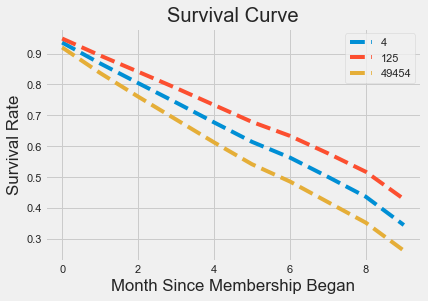

In [32]:
# check out individual plots (choose several indices to examine)
subject = [4, 125, 49454]
cph_pred[subject].plot(ls="--") 
plt.ylabel('Survival Rate')
plt.xlabel('Month Since Membership Began')
plt.title("Survival Curve")
plt.show()

### Prediction



In [33]:
# Use Median prediction
median_pred = cph.predict_median(pred_df)

# Merge back to the test data set
df2['median_pred'] = median_pred

### Inf values in Prediction
I noticed that the model is unable to predict, assigning infinite values to about 17% of these members who paid their monthly fee in May-2019. A closer look at this population reveals that these members are longer tenured members, on average, they having been paying more than 8 months. 

One likely explanation is, we don't have many cohorts that are seasoned so the model is unable to predict members who have been paying longer than 8, 9, or 10 months. Gathering more seasoned data will obviously be helpful, if that's not feasible in practice, we will have to explore other model options that were discussed in Q4. 

Here, I am simplying adding 6 months to the current age to treat these inf values.

In [34]:
print("% of Inf predicted:", (df2[df2['median_pred']== np.inf]['Customer ID'].count()/May2019_fee_total).round(2)*100)

print("Their Avg Age:", df2[df2['median_pred']== np.inf]['Age'].mean())

% of Inf predicted: 17.0
Their Avg Age: 8.325316455696203


In [35]:
# Output File: Prediction 
prediction = df2[['Customer ID', 'Cohort', 'Age', 'median_pred']]

# treat inf values
prediction['median_pred'] = np.where(prediction['median_pred']==np.inf, (prediction['Age']+6), prediction['median_pred'])

# Create membership end date
plus_month_period = (prediction['median_pred']- prediction['Age']).astype(int)
prediction['membership_end_date'] = prediction['Cohort'] + plus_month_period
prediction.head()

,Customer ID,Cohort,Age,median_pred,membership_end_date
4,386379,2019-02,3,8.0,2019-07
9,385532,2019-02,3,8.0,2019-07
14,382351,2019-02,3,8.0,2019-07
24,363517,2019-01,4,8.0,2019-05
31,362304,2018-12,5,9.0,2019-04


### Output File

In [36]:
prediction.to_csv("output.csv", index=True, header=True)